In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim

import tqdm.notebook as tqdm


from bal import data, layers


In [3]:
xs, ys = data.generate_1d_regression(
    n_points=1000,
    domain=(-1, 3), 
    noise_std=0.1, 
    seed=7
)

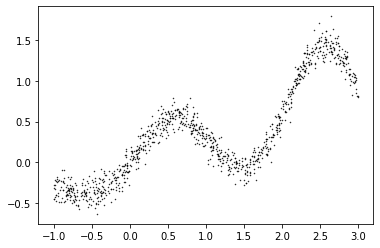

In [4]:
fig, ax = plt.subplots()
ax.scatter(xs, ys, s=0.2, color="black")

In [25]:
class AdaptiveNet(nn.Module):
    def __init__(self, in_features, h_size, out_features):
        super(AdaptiveNet, self).__init__()
        self.fc1 = nn.Linear(in_features, h_size)
        self.ada1 = layers.AdaptiveSize(
            min_size=1,
            max_size=h_size,
            prior_size_loc=50,
            prior_size_scale=1,
            temperature=3.0
        )
        self.lik = layers.GaussianLikelihood(mode="homoscedastic")
        self.fc2 = nn.Linear(h_size, out_features)
        self.bayesian_layers = [self.ada1]

    def forward(self, inp):
        out = nn.functional.relu(self.fc1(inp))
        out = self.ada1(out)
        out = self.fc2(out)
        return out

    def log_likelihood(self, xs, ys):
        params = self.forward(xs)
        logprobs = self.lik(params).log_prob(ys)
        return logprobs
    
    def kl_qp(n_samples=100):
        kls = []
        for bl in self.bayesian_layers:
            samples_q = bl.posterior.sample((n_samples,))
            kls.append(torch.mean(
                dist_q.log_prob(samples_q) - dist_p.log_prob(samples_q)
            ))
        return torch.sum(kls)
        

In [31]:
xs_t = torch.as_tensor(xs, dtype=torch.float32)
ys_t = torch.as_tensor(ys, dtype=torch.float32)
net = AdaptiveNet(
    in_features=1,
    h_size=50,
    out_features=1
)
opt = optim.Adam(net.parameters(), lr=1e-3)

In [32]:
pbar = tqdm.tqdm(range(4000))
for i in pbar:
    opt.zero_grad()
    nll = -torch.mean(net.log_likelihood(xs_t, ys_t))
    nll.backward()
    opt.step()
    nll_val = nll.detach().numpy()
    infered_scale = nn.functional.softplus(net.lik.var_spi_scale.detach()).numpy()
    lsize = net.ada1.var_loc.detach().numpy()
    pbar.set_description_str(
        f"loss: {nll_val:5.4f}, " 
        f"scale: {infered_scale:4.3f}, " 
        f"size: {lsize:5.2f}"
    )